## 8. 프로젝트 : 개선된 U-Net 모델 만들기

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.

2018년에 **U-Net++** 라는 논문이 나왔습니다.   
이 논문은 <span style='color:red'> 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.</span>

그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.

* (참고) [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)

<img align='center' width='50%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/GC-5-P-UNPP.max-800x600.png'/>

## Step 1. KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다.   
U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다.   
8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

### 데이터 로더(data loader) 만들기

In [5]:
#필요한 라이브러리 로드 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [6]:
# albumentation을 사용한 augmentation 
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    # 훈련용 데이터일 경우
    if is_train:    
        # augmentation 기법을 확률적으로 적용
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    # 테스트용 데이터일 경우
    return Compose([       
                  Resize(          # 224X224로 resize만 수행
                      width=224,
                      height=224
                      )
                  ])

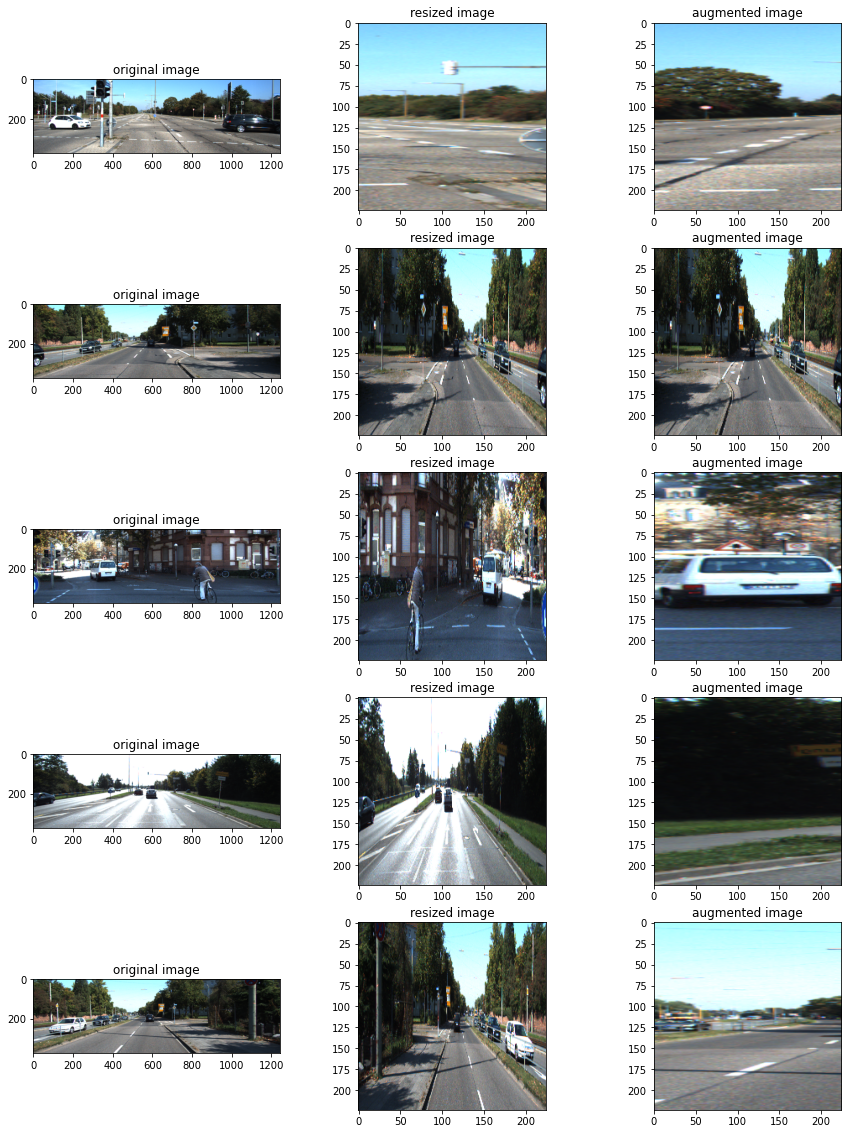

In [7]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(15, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    
    plt.subplot(5, 3, 3*i+1)
    plt.title("original image")
    plt.imshow(image)               # 왼쪽이 원본 이미지   
    plt.subplot(5, 3, 3*i+2)    
    plt.title("resized image")
    plt.imshow(resized["image"])    # 가운데가 resized된 이미지
    plt.subplot(5, 3, 3*i+3)
    plt.title("augmented image")
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

* **augmentation(` **image_data`)** : 
  - [참고: 함수 인자 `*args와 **kwargs`](https://brunch.co.kr/@princox/180)
  - [참고: 함수의 매개변수(parameter) 특징](https://ychae-leah.tistory.com/65)

  - 함수 인자의 순서 : **`일반 변수, *변수, **변수`**

  - **`*args`** 는 **`*arguments`** 의 줄임말
    - 여러 개의 인자를 함수로 받고자 할 때 사용
    - 함수 내부에서는 튜플로 받은 것처럼 인식한다

  - **` **kwargs`** 는 **` **keyword arguments`** 의 줄임말
    - (키워드 = 특정 값) 형태로 함수를 호출할 때 사용
    - 딕셔너리 형태로 {'키워드': '특정값'} 함수 내부로 전달한다

In [8]:
# generator 형태로 데이터셋 구성
class KittiGenerator(tf.keras.utils.Sequence):
    
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=4,           # 16 : OOM 발생
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
  
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
    
        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
  
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
  
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [9]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다.   
이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

### U-Net 모델

<img align='center' width='60%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/u-net_1kfpgqE.max-800x600.png'/>
<div style='text-align:center'> U-Net 구조 </div>

#### U-Net 모델 구조 만들기-1

In [16]:
def conv_down(inputs, n_filter, stage, k_size=3, act='relu', pad='same', k_init='he_normal'):
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(inputs)
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cd)
    return cd


def conv_up(inputs, n_filter, mrg, stage, act='relu', pad='same', k_init='he_normal' ):
    cu = Conv2D(filters=n_filter, kernel_size=(2, 2), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(UpSampling2D(size = (2,2))(inputs)) 
    cc = concatenate([mrg, cu], axis = 3)
    cd = Conv2D(filters=n_filter, kernel_size=(3, 3), name='conv'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cc)
    cd = Conv2D(filters=n_filter, kernel_size=(3, 3), name='conv'+stage+'3', activation=act, padding=pad, kernel_initializer=k_init)(cd)    
    return cd

In [17]:
# U-Net 모델 구조 만들기
def build_model_unet(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)
  
      #Contracting Path
    cd1 = conv_down(inputs, n_filter=64, stage='dn11')
    mp1 = MaxPooling2D(pool_size=(2, 2))(cd1)

    cd2 = conv_down(mp1, n_filter=128, stage='dn21')
    mp2 = MaxPooling2D(pool_size=(2, 2))(cd2)
    
    cd3 = conv_down(mp2, n_filter=256, stage='dn31')
    mp3 = MaxPooling2D(pool_size=(2, 2))(cd3)
    
    cd4 = conv_down(mp3, n_filter=512, stage='dn41')
    do4 = Dropout(0.5)(cd4)
    mp4 = MaxPooling2D(pool_size=(2, 2))(do4)
    
    cd5 = conv_down(mp4, n_filter=1024, stage='dn51')
    do5 = Dropout(0.5)(cd5)
    
    
      #Expanding Path
    cu4 = conv_up(do5, n_filter=512, mrg=do4, stage='up4')  # MaxPooling2D 전의 층과 merge 시킨다.
    cu3 = conv_up(cu4, n_filter=256, mrg=cd3, stage='up3')
    cu2 = conv_up(cu3, n_filter=128, mrg=cd2, stage='up2')
    cu1 = conv_up(cu2, n_filter= 64, mrg=cd1, stage='up1')
    
    outs = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(cu1)  
    outs = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(outs)
  
    model = Model(inputs = inputs, outputs = outs)
    return model

In [18]:
model_unet = build_model_unet()
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
convdn111 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
convdn112 (Conv2D)              (None, 224, 224, 64) 36928       convdn111[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 64) 0           convdn112[0][0]                  
____________________________________________________________________________________________

#### U-Net 모델 구조 만들기-2

In [25]:
def conv_down2(inputs, n_filter, stage, k_size=3, act='relu', pad='same', k_init='he_normal'):
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(inputs)
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cd)
    return cd


def conv_up2(inputs, n_filter, mrg, stage, act='relu', pad='same', k_init='he_normal' ):
    cu = Conv2D(filters=n_filter, kernel_size=(2, 2), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(UpSampling2D(size = (2,2))(inputs)) 
    cc = concatenate([mrg, cu], axis = 3)
    return cc

In [26]:
# U-Net 모델 구조 만들기
def build_model_unet2(input_shape=(224, 224, 3)):
    model = None

    inputs = Input(input_shape)
  
    # Contracting Path
    cd1 = conv_down2(inputs, n_filter=64, stage='dn11')
    mp1 = MaxPooling2D(pool_size=(2, 2))(cd1)

    cd2 = conv_down2(mp1, n_filter=128, stage='dn21')
    mp2 = MaxPooling2D(pool_size=(2, 2))(cd2)
    
    cd3 = conv_down2(mp2, n_filter=256, stage='dn31')
    mp3 = MaxPooling2D(pool_size=(2, 2))(cd3)
    
    cd4 = conv_down2(mp3, n_filter=512, stage='dn41')
    do4 = Dropout(0.5)(cd4)
    mp4 = MaxPooling2D(pool_size=(2, 2))(do4)
    
    cd5 = conv_down(mp4, n_filter=1024, stage='dn51')
    do5 = Dropout(0.5)(cd5)
    
    
    # Expanding Path
    cu4 = conv_up2(do5, n_filter=512, mrg=do4, stage='up4')  # MaxPooling2D 전의 층과 merge 시킨다.
    cd4_2 = conv_down2(cu4, n_filter=512, stage='dn42')
    
    cu3 = conv_up2(cd4_2, n_filter=256, mrg=cd3, stage='up3')
    cd3_2 = conv_down2(cu3, n_filter=256, stage='dn32')
    
    cu2 = conv_up2(cd3_2, n_filter=128, mrg=cd2, stage='up2')
    cd2_2 = conv_down2(cu2, n_filter=128, stage='dn22')
    
    cu1 = conv_up2(cd2_2, n_filter= 64, mrg=cd1, stage='up1')
    cd1_2 = conv_down2(cu1, n_filter=64, stage='dn12')
    
    outs = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(cd1_2)  
    outs = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(outs)
  
    model = Model(inputs = inputs, outputs = outs)
    return model

In [27]:
model_unet2 = build_model_unet2()
model_unet2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
convdn111 (Conv2D)              (None, 224, 224, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
convdn112 (Conv2D)              (None, 224, 224, 64) 36928       convdn111[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 112, 112, 64) 0           convdn112[0][0]                  
____________________________________________________________________________________________

In [30]:
# # 전처리 부분도 224--> 572로 수정해야만 함
# model_unet572 = build_model_unet(input_shape=(572, 572, 3))
# model_unet572.summary()

#### 모델 학습하기

In [10]:
# 모델 학습하기
model_unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

model_unet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
 )

model_unet_path = dir_path + '/seg_model_unet.h5'
model_unet.save(model_unet_path)  #학습한 모델을 저장해 주세요.

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 42s 205ms/step - loss: 0.6800 - val_loss: 0.2602
Epoch 2/100
43/43 [==============================] - 9s 198ms/step - loss: 0.6751 - val_loss: 0.6834
Epoch 3/100
43/43 [==============================] - 9s 200ms/step - loss: 0.6032 - val_loss: 0.1094
Epoch 4/100
43/43 [==============================] - 9s 206ms/step - loss: 0.1390 - val_loss: 0.1166
Epoch 5/100
43/43 [==============================] - 8s 186ms/step - loss: 0.0916 - val_loss: 0.1010
Epoch 6/100
43/43 [==============================] - 8s 186ms/step - loss: 0.1158 - val_loss: 0.0823
Epoch 7/100
43/43 [==============================] - 8s 183ms/step - loss: 0.0811 - val_loss: 0.0749
Epoch 8/100
43/43 [==============================] - 8s 185ms/step - loss: 0.0729 - val_loss: 0.0729
Epoch 9/100
43/43 [==============================] - 8s 182ms/step - loss: 0.0699 - val_loss: 0.0850
Epoch 10/100
43/43 [==============================] - 8s 183ms/step - loss: 0.0699 - val_l

### U-Net++ 모델

* [참고1](https://engineer-mole.tistory.com/40)
* [참고2](https://github.com/CarryHJR/Nested-UNet)

* [참고3](https://github.com/MrGiovanni/UNetPlusPlus)
* [참고4](https://github.com/MrGiovanni/UNetPlusPlus/tree/master/keras/segmentation_models/unet)

<img align='center' width='80%' src='https://miro.medium.com/max/658/1*ExIkm6cImpPgpetFW1kwyQ.png'/>
<div style='text-align:center'> U-Net++ 구조 </div>

#### re-designed skip pathways

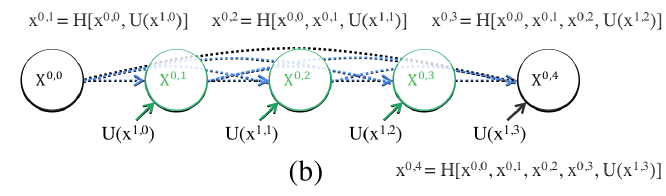
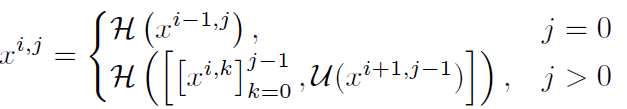


* <span style='color:red'> `H()`는 convolution 동작 다음의 활성화 함수이며,</span>       
* <span style='color:red'> `U()`는 up-sampling layer을 나타낸다. 그리고 </span>       
* <span style='color:red'> `[]`는 concatenation layer을 나타낸다.</span>   

* [참고](https://engineer-mole.tistory.com/40)

*  let $\textbf x^{i,j}$ denote the output of **node $X^{i,j}$** 
   - **i indexes** the down-sampling layer **along the encoder** and 
   - **j indexes** the convolution layer of the dense block **along the skip pathway**.


**`function H(·)`** is a **convolution operation** followed by an **activation function,**   
**`function U(·)`** denotes an **up-sampling layer**, and   
**`[ ]`** denotes the **concatenation layer**.  


Basically, 
* **`nodes at level j = 0`** receive **only one input** from the **previous layer of the encoder**; 
* **`nodes at level j = 1`** receive **two inputs**, 
  - both from the encoder sub-network but at two consecutive levels; and 
* **`nodes at level j > 1`** receive **(j + 1) inputs**, of which 
  - `j inputs` are the **outputs of the previous j nodes** in the **same skip pathway** 
  - and the `last input` is the **up-sampled output** from the **lower skip pathway**.
  

#### U-Net++ 모델 구조 만들기

In [28]:
def conv_net(inputs, n_filter, stage, k_size=3, act='relu', pad='same', k_init='he_normal'):
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='cd'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(inputs)
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='cd'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cd)
    return cd


def ups_cctn(inputs, n_filter, mrg, stage, act='relu', pad='same', k_init='he_normal' ):
    cu = Conv2D(filters=n_filter, kernel_size=(2, 2), name='up'+stage, activation=act, padding=pad, kernel_initializer=k_init)(UpSampling2D(size = (2,2))(inputs)) 
    cc = concatenate([mrg, cu], axis = 3)
    return cc

* `tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest', **kwargs)` : 
  - Repeats the rows and columns of the data by `size[0]` and `size[1]` respectively.
  - `size` : Int, or tuple of 2 integers. The upsampling factors for rows and columns.
  - `interpolation` :	A string, one of nearest or bilinear.
  - [참고](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)

* [UpSampling2D 와 Conv2DTranspose의 차이](http://machinelearningkorea.com/2019/08/25/upsampling2d-와-conv2dtranspose의-차이/)

* [How to use the UpSampling2D and Conv2DTranspose Layers in Keras](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/)


In [29]:
def UNet_PP(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
        img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    else:
        bn_axis = 1
        img_input = Input(shape=(color_type, img_rows, img_cols), name='main_input')

    # x(n,0) node = H(x(n-1,0))   
    conv00 = conv_net(inputs, n_filter=64, stage='0_0')
    mxpl00 = MaxPooling2D(pool_size=(2, 2), name='pool00')(conv00)

    conv10 = conv_net(mxpl00, n_filter=128, stage='1_0')
    mxpl10 = MaxPooling2D(pool_size=(2, 2), name='pool10')(conv10)
    
    conv20 = conv_net(mxpl10, n_filter=256, stage='2_0')
    mxpl20 = MaxPooling2D(pool_size=(2, 2), name='pool20')(conv20)
    
    conv30 = conv_net(mxpl20, n_filter=512, stage='3_0')
    mxpl30 = MaxPooling2D(pool_size=(2, 2), name='pool30')(conv30)
    
    conv40 = conv_net(mxpl30, n_filter=1024, stage='4_0')
    drop40 = Dropout(0.5)(conv40)

    
    # x(n, 1) node = H([[x(n, 0)], U(x(n+1, 0))]) 
    conv01 = conv_net(conv31, n_filter=512, stage='0_1')
    
    skip01 = ups_cctn(mxpl10, n_filter=512, mrg=conv00, stage='0_1')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv01 = conv_net(conv31, n_filter=512, stage='0_1')
    
    skip11 = ups_cctn(mxpl20, n_filter=256, mrg=conv10, stage='1_1')
    conv11 = conv_net(conv22, n_filter=256, stage='1_1')
    
    skip21 = ups_cctn(mxpl30, n_filter=128, mrg=conv20, stage='2_1')
    conv21 = conv_net(conv13, n_filter=128, stage='2_1')
    
    skip31 = ups_cctn(mxpl40, n_filter= 64, mrg=conv30, stage='3_1')
    conv31 = conv_net(conv04, n_filter=64, stage='3_1')
    
    
    
    # X(n, 2) Path 
    skip02 = ups_cctn(mxpl10, n_filter=512, mrg=conv00, stage='0_1')      # MaxPooling2D 전의 층과 merge 시킨다.
    skip02 = ups_cctn(mxpl10, n_filter=512, mrg=conv01, stage='0_1')
    conv02 = conv_net(conv11, n_filter=512, stage='0_1')
    
    cu12 = ups_cctn(mp20, n_filter=256, mrg=cd10, stage='1_1')
    cd12 = conv_net(cu22, n_filter=256, stage='1_1')
    
    cu22 = ups_cctn(mp30, n_filter=128, mrg=cd20, stage='2_1')
    cd22 = conv_net(cu13, n_filter=128, stage='2_1')
    
    cu32 = ups_cctn(mp40, n_filter= 64, mrg=cd30, stage='3_1')
    cd32 = conv_net(cu04, n_filter=64, stage='3_1')
    
       
    
    
    
    
    
    
    
    # Expanding Path 3
    conv31 = skip_connet(drop40, n_filter=512, mrg=conv30, stage='3_1')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv31 = conv_down_up(conv31, n_filter=512, stage='3_1')
    
    conv22 = skip_connet(conv31, n_filter=256, mrg=conv20, stage='2_2')
    conv22 = conv_down_up(conv22, n_filter=256, stage='2_2')
    
    conv13 = skip_connet(conv22, n_filter=128, mrg=conv10, stage='1_3')
    conv13 = conv_down_up(conv13, n_filter=128, stage='1_3')
    
    conv04 = skip_connet(conv13, n_filter= 64, mrg=conv00, stage='0_4')
    conv04 = conv_down_up(conv04, n_filter=64, stage='0_4')
    
    
    
    
    
    outs = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(cd1_2)  
    outs = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(outs)
      
    
    
    
    
   
    if deep_supervision:
        model = Model(input=img_input, output=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(input=img_input, output=[nestnet_output_4])

    return model

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [ ]:
def U_Net(img_rows, img_cols, color_type=1, num_class=1):
    
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(input=img_input, output=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(input=img_input, output=[nestnet_output_4])

    return model

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다.   
시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

* [UNet++ paper](https://arxiv.org/abs/1807.10165)
* [UNet++ code](https://github.com/MrGiovanni/UNetPlusPlus)
* [Nested-UNet](https://github.com/CarryHJR/Nested-UNet)

In [9]:
<img align='center' width='50%' src=''/>

<div style='text-align:center'> </div>

<span style='color:red'> </span>

SyntaxError: invalid syntax (<ipython-input-9-cb7afb609ddc>, line 1)